## Notebook for visualizing a specific QTS pairing between PD GRS and modality feature

In [1]:
!date

Mon Oct 21 09:13:03 PM UTC 2024


#### import libraries

In [2]:
from pandas import read_csv, DataFrame, read_hdf, get_dummies, concat, Series
import matplotlib.pyplot as plt
from seaborn import regplot, scatterplot
from matplotlib.pyplot import rc_context

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# parameters
modality = 'SCRN-eNP'
day = 'da65'
feature = 'KANSL1' # 'DCLRE1C'

In [4]:
# naming
cohort = 'foundin'
set_name = f'{cohort}_{day}_{modality}'

# directories
wrk_dir = '/labshare/raph/datasets/foundin_qtl'
quants_dir = f'{wrk_dir}/quants'
info_dir = f'{wrk_dir}/sample_info'
qts_dir = f'{wrk_dir}/qts'

# in files
covs_file = f'{info_dir}/{cohort}_{modality}_sample_info.csv'
grs_file = f'{info_dir}/{cohort}_grs_scaled.csv'
quants_file = f'{quants_dir}/{set_name}.scaled.adj.hdf5'
qts_file = f'{qts_dir}/{set_name}.qts.csv'

# out files

# constants
DEBUG = False
dpi_value = 50

if DEBUG:
    print(f'covs_file is {covs_file}')
    print(f'grs_file is {grs_file}')
    print(f'quants_file is {quants_file}')
    print(f'qts_file is {qts_file}')

In [5]:
#plot the QTS
def plotqts(trait_id, study_name, score_df, traits_df):
    this_scores_df = score_df.loc[score_df.index.isin(traits_df.index)]
    this_scores_df = this_scores_df.reindex(traits_df.index)

    temp = traits_df.merge(this_scores_df,left_index=True,right_index=True)

    with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
        plt.style.use('seaborn-v0_8-bright')
        regplot(x=trait_id,y='GRS', data=temp, ci=95)
        scatterplot(x=trait_id,y='GRS', data=temp, hue='DX')
        plt.xlabel('Trait')
        plt.ylabel('GRS')
        plt.title(f'{trait_id} in {study_name}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 10})
        plt.show()

### load input data

#### load the known sample covariates

In [6]:
covs_df = read_csv(covs_file, index_col=0)
print(covs_df.shape)
# if any duplicates, keep first
covs_df = covs_df[~covs_df.index.duplicated(keep='first')]
if DEBUG:
    display(covs_df.head())

(80, 88)


#### load and add GRS

In [7]:
grs_df = read_csv(grs_file)
print(grs_df.shape)
if DEBUG:
    display(grs_df.head())

(119, 3)


In [8]:
# covs_df = covs_df.merge(grs_df, how='inner', left_on='wgsid', right_on='IID')
covs_df = covs_df.reset_index().merge(grs_df, how='inner', left_on='sampleid', 
                                      right_on='IID').set_index('assayid')
print(covs_df.shape)
if DEBUG:
    display(covs_df.head())

(79, 91)


#### load the quantified modality

In [9]:
%%time
quants_df = read_hdf(quants_file, index_col=0)
print(quants_df.shape)
if DEBUG:
    display(quants_df.head())

(83, 10238)
CPU times: user 54.1 ms, sys: 15.8 ms, total: 69.9 ms
Wall time: 1.29 s


In [10]:
set(quants_df.index) - set(covs_df.index)

{'SCRN-eNP_PPMI3186_da65',
 'SCRN-eNP_PPMI3966B3_da65',
 'SCRN-eNP_PPMI3966E6_da65',
 'SCRN-eNP_PPMI3966E8_da65'}

### load the QTS results

In [11]:
qts_df = read_csv(qts_file, index_col=0)
print(f'QTS results shape {qts_df.shape}')
if DEBUG:
    display(qts_df.sample(5))

QTS results shape (10238, 6)


### prep the covariate terms for modeling

#### verify quants and covs have same indices

In [12]:
def ensure_matched_indices(df1: DataFrame, df2: DataFrame) -> {DataFrame, DataFrame}:
    """ make sure the two datasets are ordered the same
        modifies both df1 and df2
    Args:
        df1 (pandas.DataFrame)
        df2 (pandas.DataFrame)
    """ 
    print('reindexing')
    shared_indices = df1.index.intersection(df2.index)
    df1 = df1.loc[shared_indices,]
    df2 = df2.loc[shared_indices,]
    temp = df1.index.values == df2.index.values
    display(Series(temp).value_counts())
    return df1, df2

In [13]:
quants_df, covs_df = ensure_matched_indices(quants_df, covs_df)

reindexing


True    79
Name: count, dtype: int64

### get the feature of interest

In [14]:
quants_df = quants_df[feature]
if DEBUG:
    display(quants_df)

### plot the QTS

coef        -0.335356
stderr       0.069309
r2_adj       0.243135
term_cnt    14.000000
p-value      0.000009
bh_fdr       0.045086
Name: KANSL1, dtype: float64

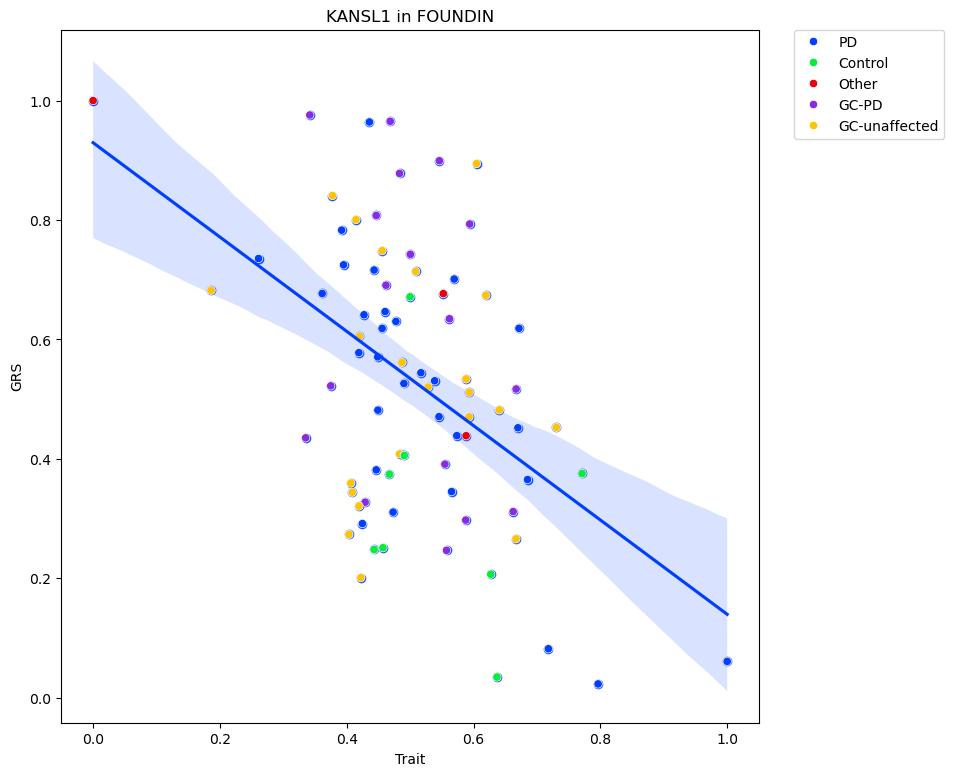

In [15]:
this_trait = qts_df.loc[feature]
display(this_trait)
plotqts(feature, cohort.upper(), covs_df, quants_df.to_frame())

In [16]:
!date

Mon Oct 21 09:13:07 PM UTC 2024
